# 0) Import des Librairies

---



In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import missingno as msno
import seaborn as sns
import plotly.figure_factory as ff

import numpy as np

In [27]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


C:\Users\edmee\AppData\Local\Temp\ipykernel_19744\3516681846.py:5: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.



In [ ]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',30)

In [13]:
df=pd.read_csv('./Data/station_paris.csv')

### Visualisation des observations de hauteur par date

In [15]:
df['date_obs_elab'] = pd.to_datetime(df['date_obs_elab'])

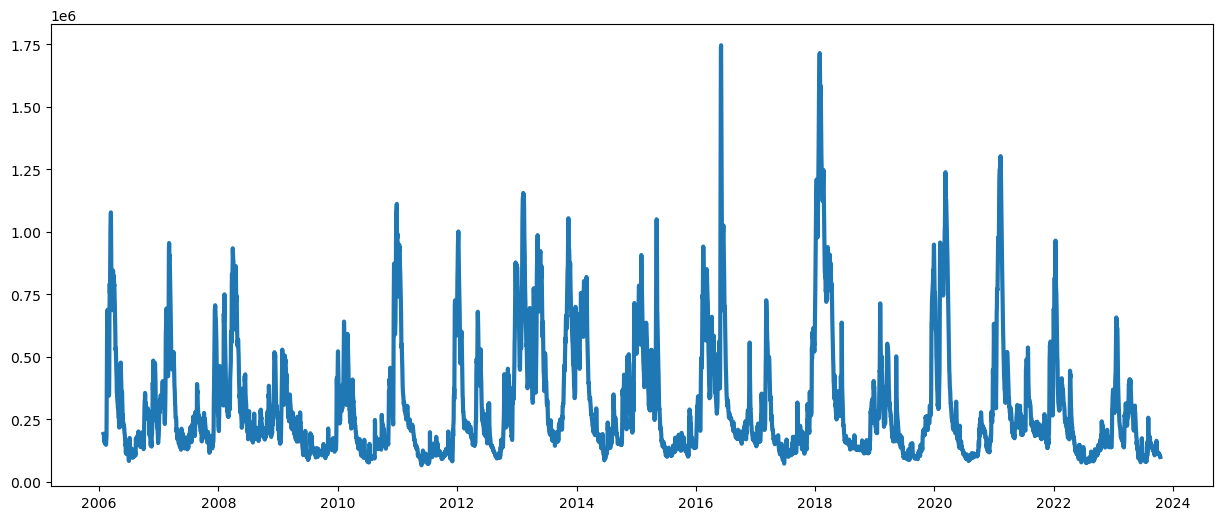

In [16]:
plt.figure(figsize=(15, 6))
plt.plot(df["date_obs_elab"], df["resultat_obs_elab"], linewidth=3)

In [17]:
fig = px.histogram(df, x="resultat_obs_elab")
fig.show()

In [18]:

fig = px.box(df, y="resultat_obs_elab")

fig.show(renderer="colab")

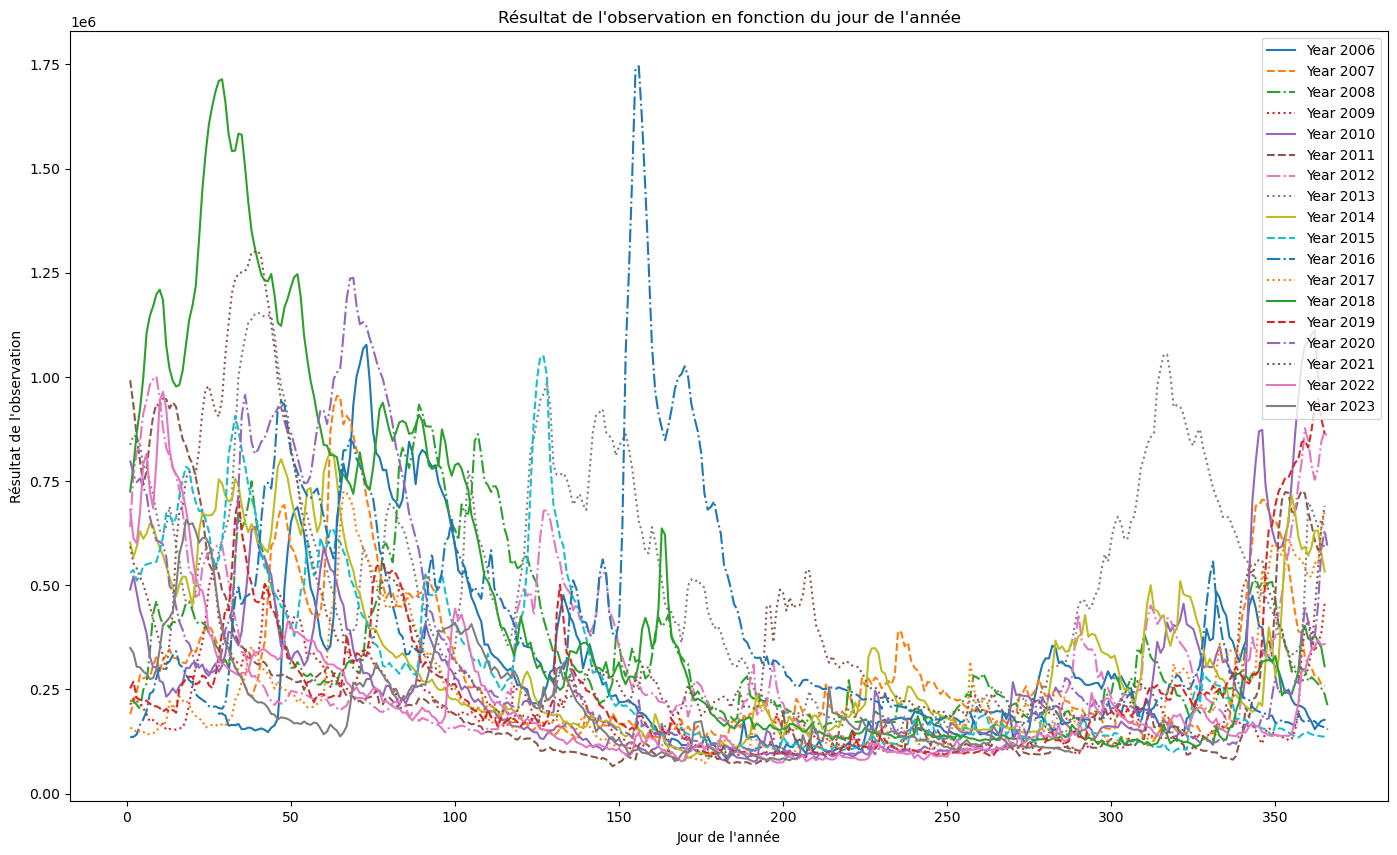

In [19]:
df['year'] = df['date_obs_elab'].dt.year

plt.figure(figsize=(17, 10))

# Définir les styles de ligne disponibles
styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-']

for i, (year, group) in enumerate(df.groupby('year')):
    day_of_year = group['date_obs_elab'].dt.dayofyear
    plt.plot(day_of_year, group['resultat_obs_elab'], label=f'Year {year}', linestyle=styles[i % len(styles)])

plt.xlabel('Jour de l\'année')
plt.ylabel('Résultat de l\'observation')
plt.title('Résultat de l\'observation en fonction du jour de l\'année')
plt.legend(loc='upper right')

plt.show()

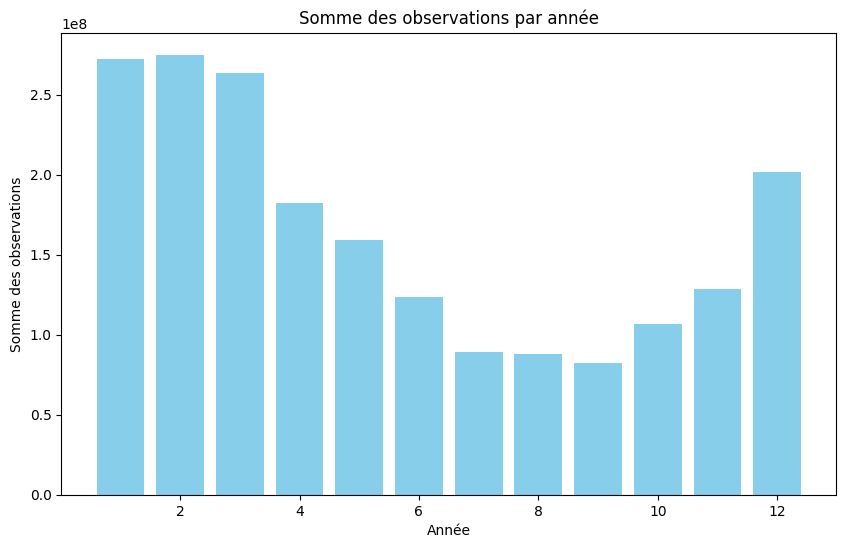

In [ ]:
df['month'] = df['date_obs_elab'].dt.month

summed_data = df.groupby('month')['resultat_obs_elab'].sum()

plt.figure(figsize=(10, 6))

plt.bar(summed_data.index, summed_data.values, color='skyblue')
plt.xlabel('Année')
plt.ylabel('Somme des observations')
plt.title('Somme des observations par année')
plt.show()

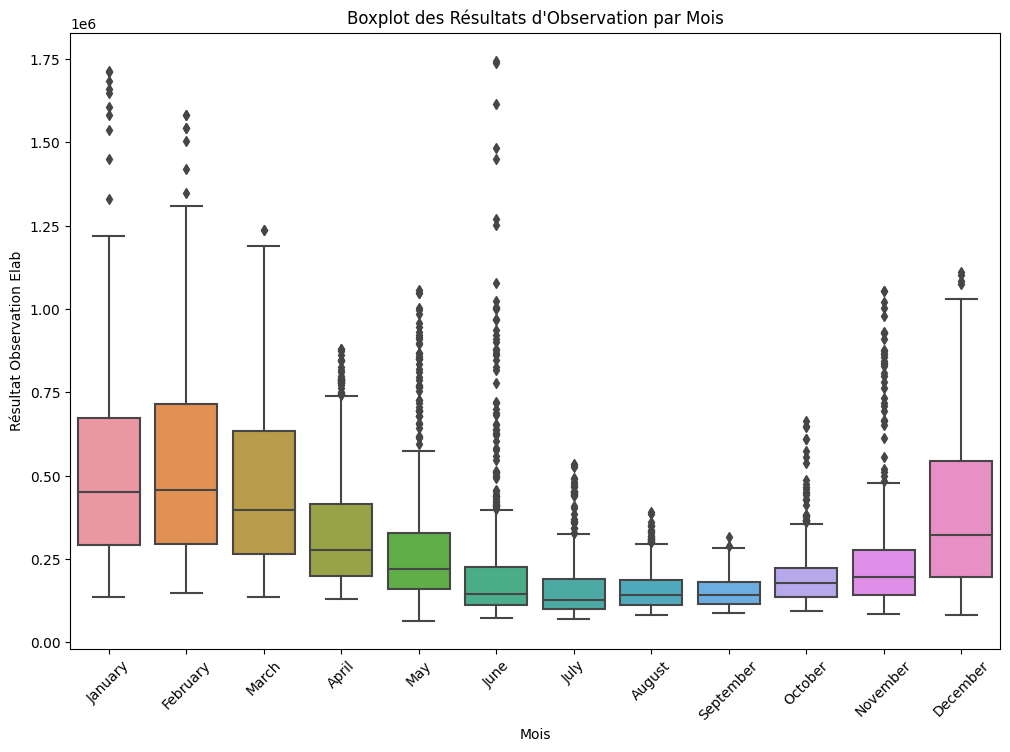

In [ ]:
df['Mois'] = df['date_obs_elab'].dt.month_name()

plt.figure(figsize=(12, 8))
sns.boxplot(x='Mois', y='resultat_obs_elab', data=df)

plt.xlabel('Mois')
plt.ylabel('Résultat Observation Elab')
plt.title('Boxplot des Résultats d\'Observation par Mois')

plt.xticks(rotation=45)
plt.show()


In [ ]:
a=df.groupby(["month"]).max()["resultat_obs_elab"]

<Axes: xlabel='month'>

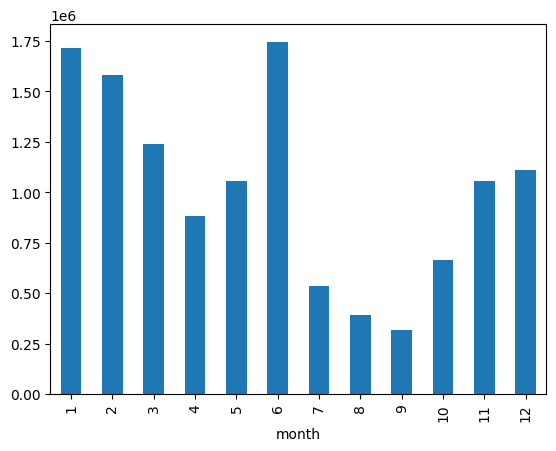

In [ ]:
a.plot(kind='bar')

# 4) Modélisation time series exemple :

In [20]:
df['date_obs_elab'] = pd.to_datetime(df['date_obs_elab'])

In [21]:
ts = df[(df['date_obs_elab'].dt.year <2023)]

In [22]:
ts=ts[["date_obs_elab", "resultat_obs_elab"]]

## Exploration des tendances et saisonnalités

<Figure size 5600x2600 with 0 Axes>

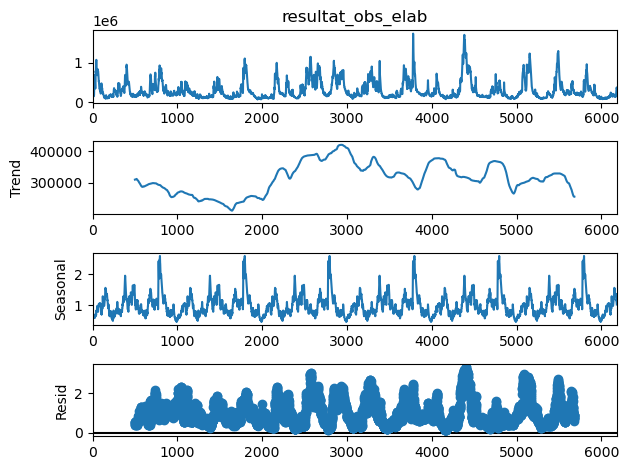

In [23]:

plt.figure(figsize=(56, 26))

result = seasonal_decompose(ts['resultat_obs_elab'], model='multiplicative', period=1000)

result.plot()
plt.show()

<Figure size 4600x1600 with 0 Axes>

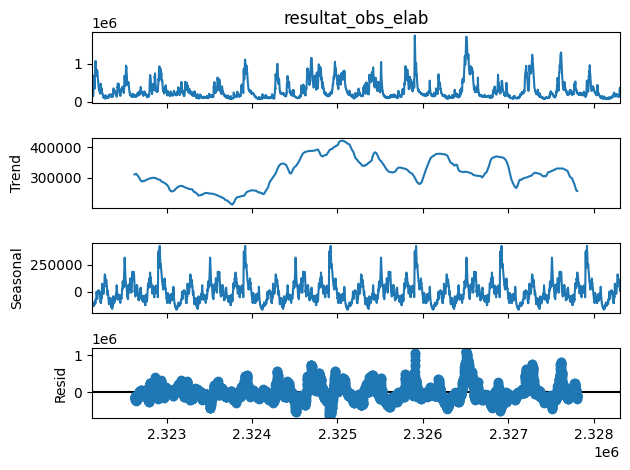

In [ ]:

plt.figure(figsize=(46, 16))

result = seasonal_decompose(ts['resultat_obs_elab'], model='additive', period=1000)

result.plot()
plt.show()


Pas l'air d'avoir de tendances, mais peut etre saisonalié

## Exploration de la saisonalité

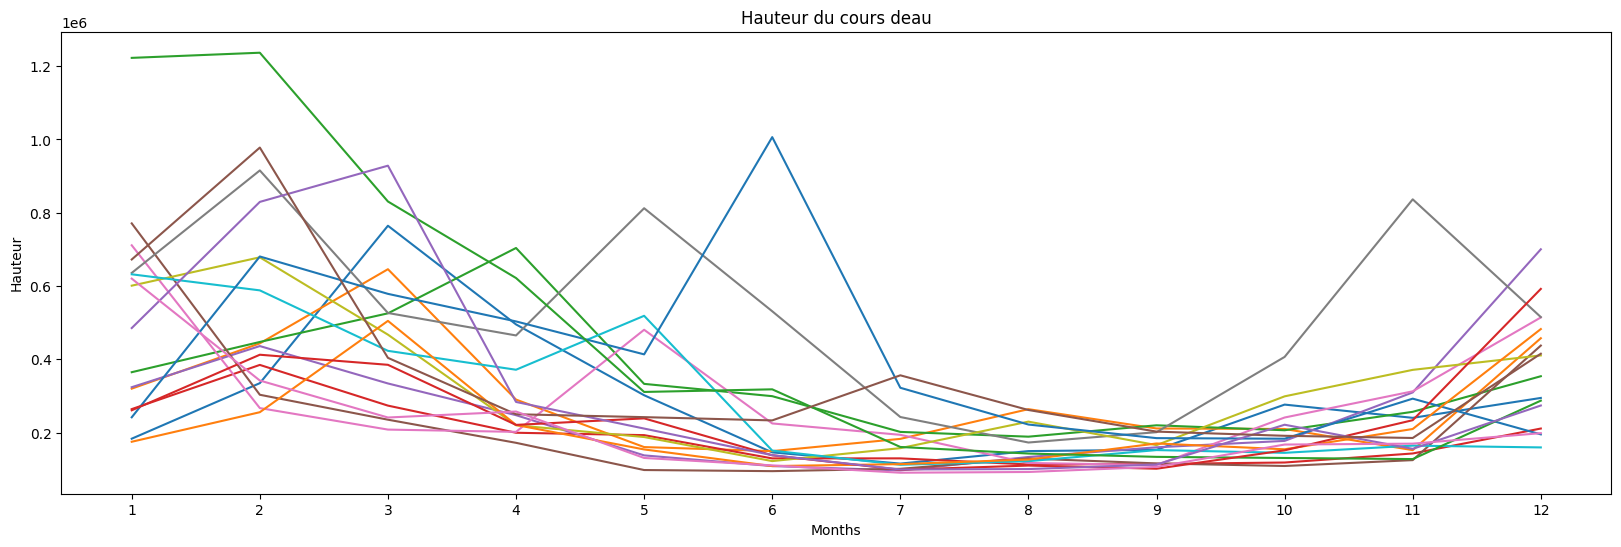

In [ ]:
ts['month'] = ts['date_obs_elab'].dt.month
ts['year'] = ts['date_obs_elab'].dt.year
pivot = pd.pivot_table(ts, values='resultat_obs_elab', index='month', columns='year', aggfunc='mean')
pivot.plot(figsize=(20,6))
plt.title('Hauteur du cours deau')
plt.xlabel('Months')
plt.ylabel('Hauteur')
plt.xticks([x for x in range(1,13)])
plt.legend().remove()
plt.show()

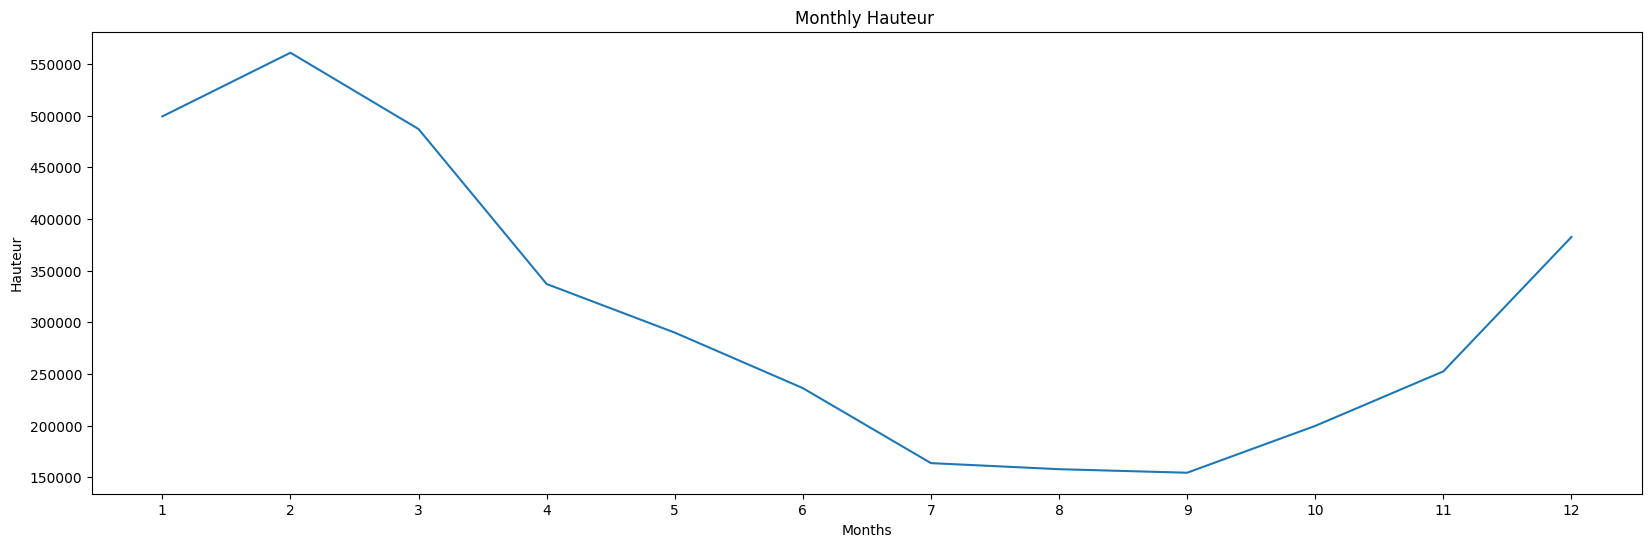

In [ ]:
monthly_seasonality = pivot.mean(axis=1)
monthly_seasonality.plot(figsize=(20,6))
plt.title('Monthly Hauteur ')
plt.xlabel('Months')
plt.ylabel('Hauteur')
plt.xticks([x for x in range(1,13)])
plt.show()

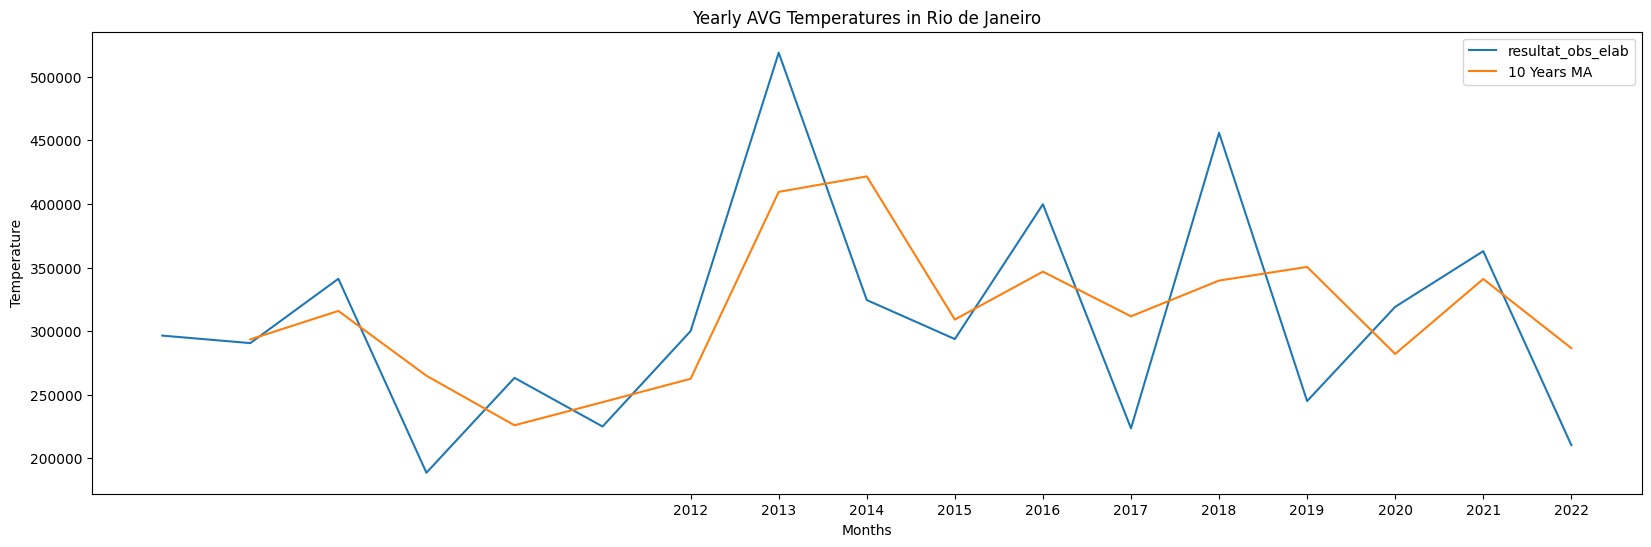

In [ ]:
year_avg = pd.pivot_table(ts, values='resultat_obs_elab', index='year', aggfunc='mean')
year_avg['10 Years MA'] = year_avg['resultat_obs_elab'].rolling(2).mean()
year_avg[['resultat_obs_elab','10 Years MA']].plot(figsize=(20,6))
plt.title('Yearly AVG Hauteur deau')
plt.xlabel('Months')
plt.ylabel('Temperature')
plt.xticks([x for x in range(2012,2023)])
plt.show()

Pas de trend

In [24]:
decompose_data = seasonal_decompose(ts['resultat_obs_elab'], model="additive", period=2000)

## Test de stationnarité

In [25]:

resultat_obs_elab = ts['resultat_obs_elab']
result = adfuller(resultat_obs_elab)

print('Statistique ADF :', result[0])
print('p-value :', result[1])
print('Lags utilisés :', result[2])
print('Nombre d\'observations utilisées :', result[3])
print('Valeurs critiques :', result[4])


Statistique ADF : -7.506487693804679
p-value : 4.12163444074127e-11
Lags utilisés : 11
Nombre d'observations utilisées : 6170
Valeurs critiques : {'1%': -3.431410295408432, '5%': -2.8620085554741395, '10%': -2.567019409281592}


Ainsi, la ST semble stationnaire

## Visualisation de l'autocorrélation

C:\Users\edmee\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



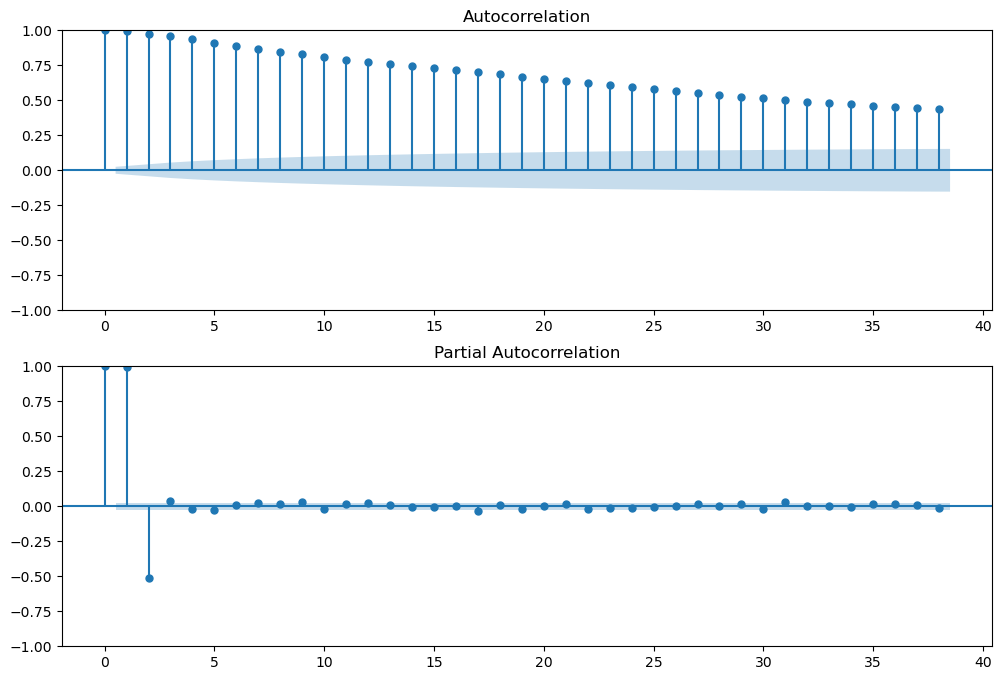

In [28]:


fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(resultat_obs_elab, ax=ax[0])
plot_pacf(resultat_obs_elab, ax=ax[1])
plt.show()


# Modélisation

In [29]:
timeSeries = df.loc[:, ["date_obs_elab","resultat_obs_elab"]]
timeSeries.index = timeSeries.date_obs_elab
ts = timeSeries.drop("date_obs_elab",axis=1)

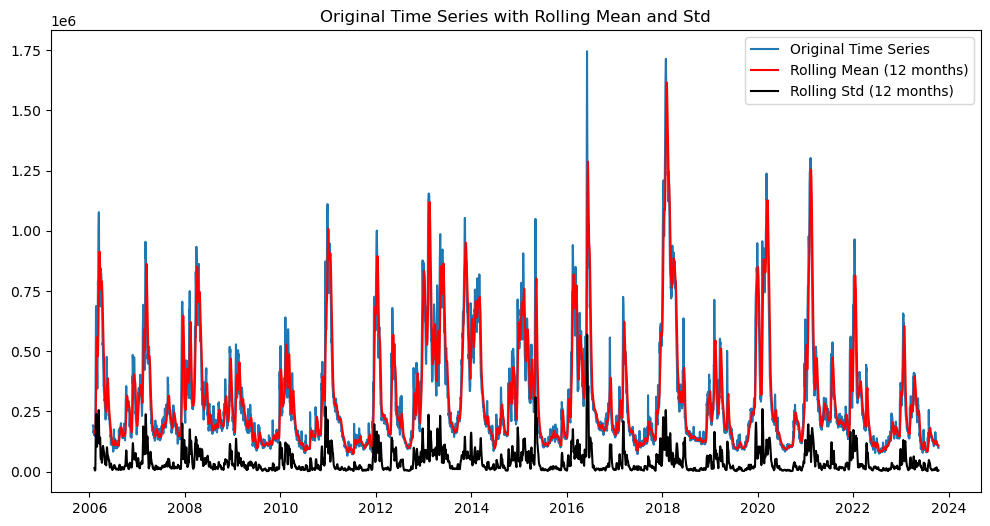

ADF Statistic: -7.647250100714841
p-value: 1.8287331404150757e-11
Critical Values: {'1%': -3.4313629918181077, '5%': -2.8619876550915135, '10%': -2.567008283518796}
Is the time series stationary? Yes


In [30]:
def check_mean_std(ts):
    rolling_mean = ts.rolling(window=12).mean()
    rolling_std = ts.rolling(window=12).std()

    plt.figure(figsize=(12, 6))
    plt.plot(ts, label='Original Time Series')
    plt.plot(rolling_mean, label='Rolling Mean (12 months)', color='red')
    plt.plot(rolling_std, label='Rolling Std (12 months)', color='black')
    plt.legend()
    plt.title('Original Time Series with Rolling Mean and Std')
    plt.show()

def check_adfuller(ts):
    result = adfuller(ts['resultat_obs_elab'])
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary? ' + ('Yes' if result[1] < 0.05 else 'No'))


check_mean_std(ts['resultat_obs_elab'])
check_adfuller(ts)

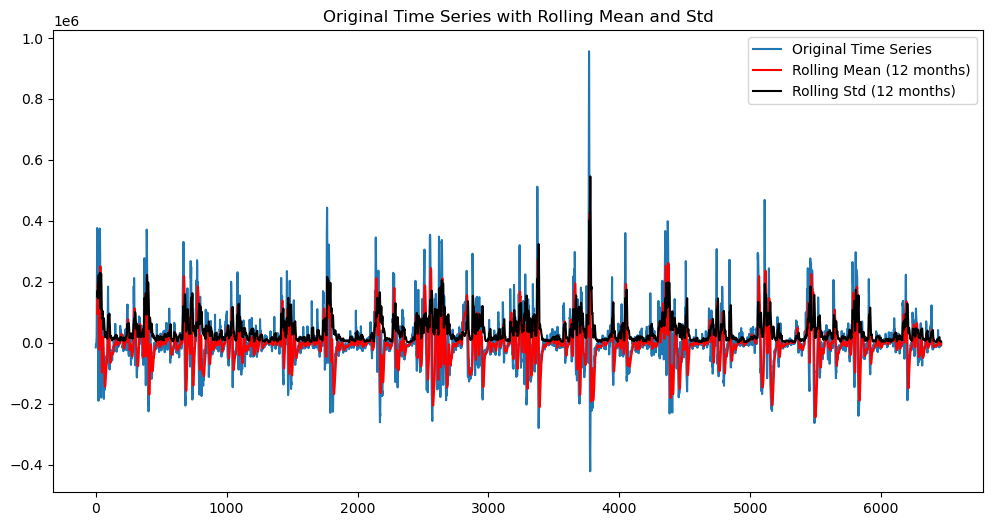

ADF Statistic: -16.04671560318514
p-value: 5.834022799123155e-29
Critical Values: {'1%': -3.431367563058534, '5%': -2.8619896748401086, '10%': -2.5670093586757545}
Is the time series stationary? Yes


In [31]:
rolling_mean = ts['resultat_obs_elab'].rolling(window=12).mean()

#On enleve la saisonalité
ts_moving_avg_diff = ts['resultat_obs_elab'] - rolling_mean
ts_moving_avg_diff.dropna(inplace=True)  # first 12 values are nan due to window size

ts_moving_avg_diff=ts_moving_avg_diff.reset_index()
check_mean_std(ts_moving_avg_diff['resultat_obs_elab'])
check_adfuller(ts_moving_avg_diff)

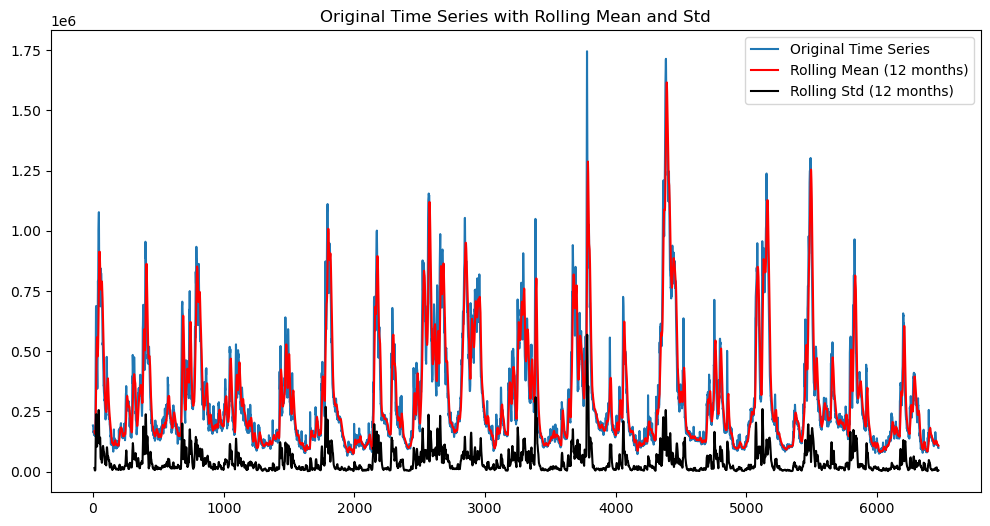

ADF Statistic: -7.647250100714841
p-value: 1.8287331404150757e-11
Critical Values: {'1%': -3.4313629918181077, '5%': -2.8619876550915135, '10%': -2.567008283518796}
Is the time series stationary? Yes


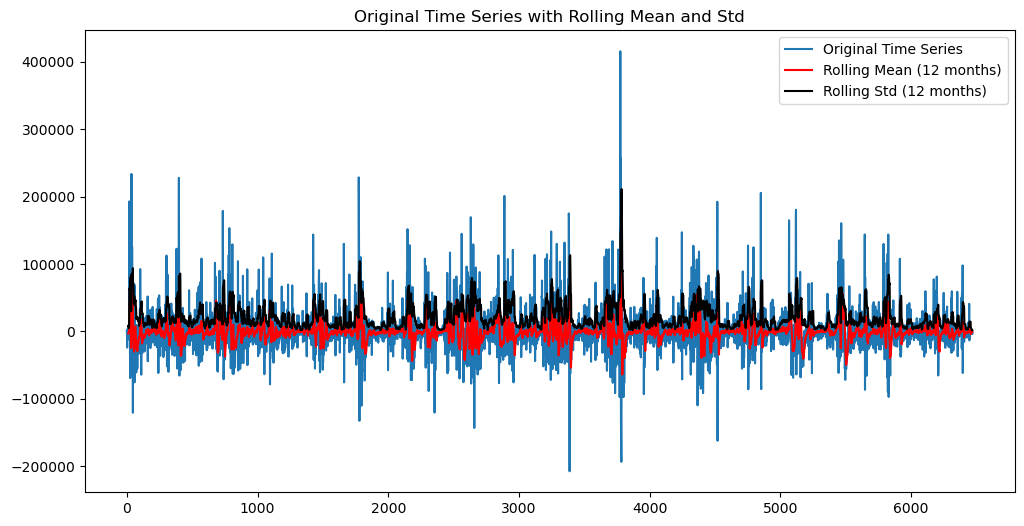

ADF Statistic: -24.91686695069561
p-value: 0.0
Critical Values: {'1%': -3.4313631487632765, '5%': -2.8619877244359344, '10%': -2.56700832043236}
Is the time series stationary? Yes


In [33]:
# differencing method
ts_diff = ts - ts.shift()

check_mean_std(ts.reset_index()['resultat_obs_elab'])
check_adfuller(ts.reset_index())

ts_diff.dropna(inplace=True)
check_mean_std(ts_diff.reset_index()['resultat_obs_elab'])
check_adfuller(ts_diff.reset_index())

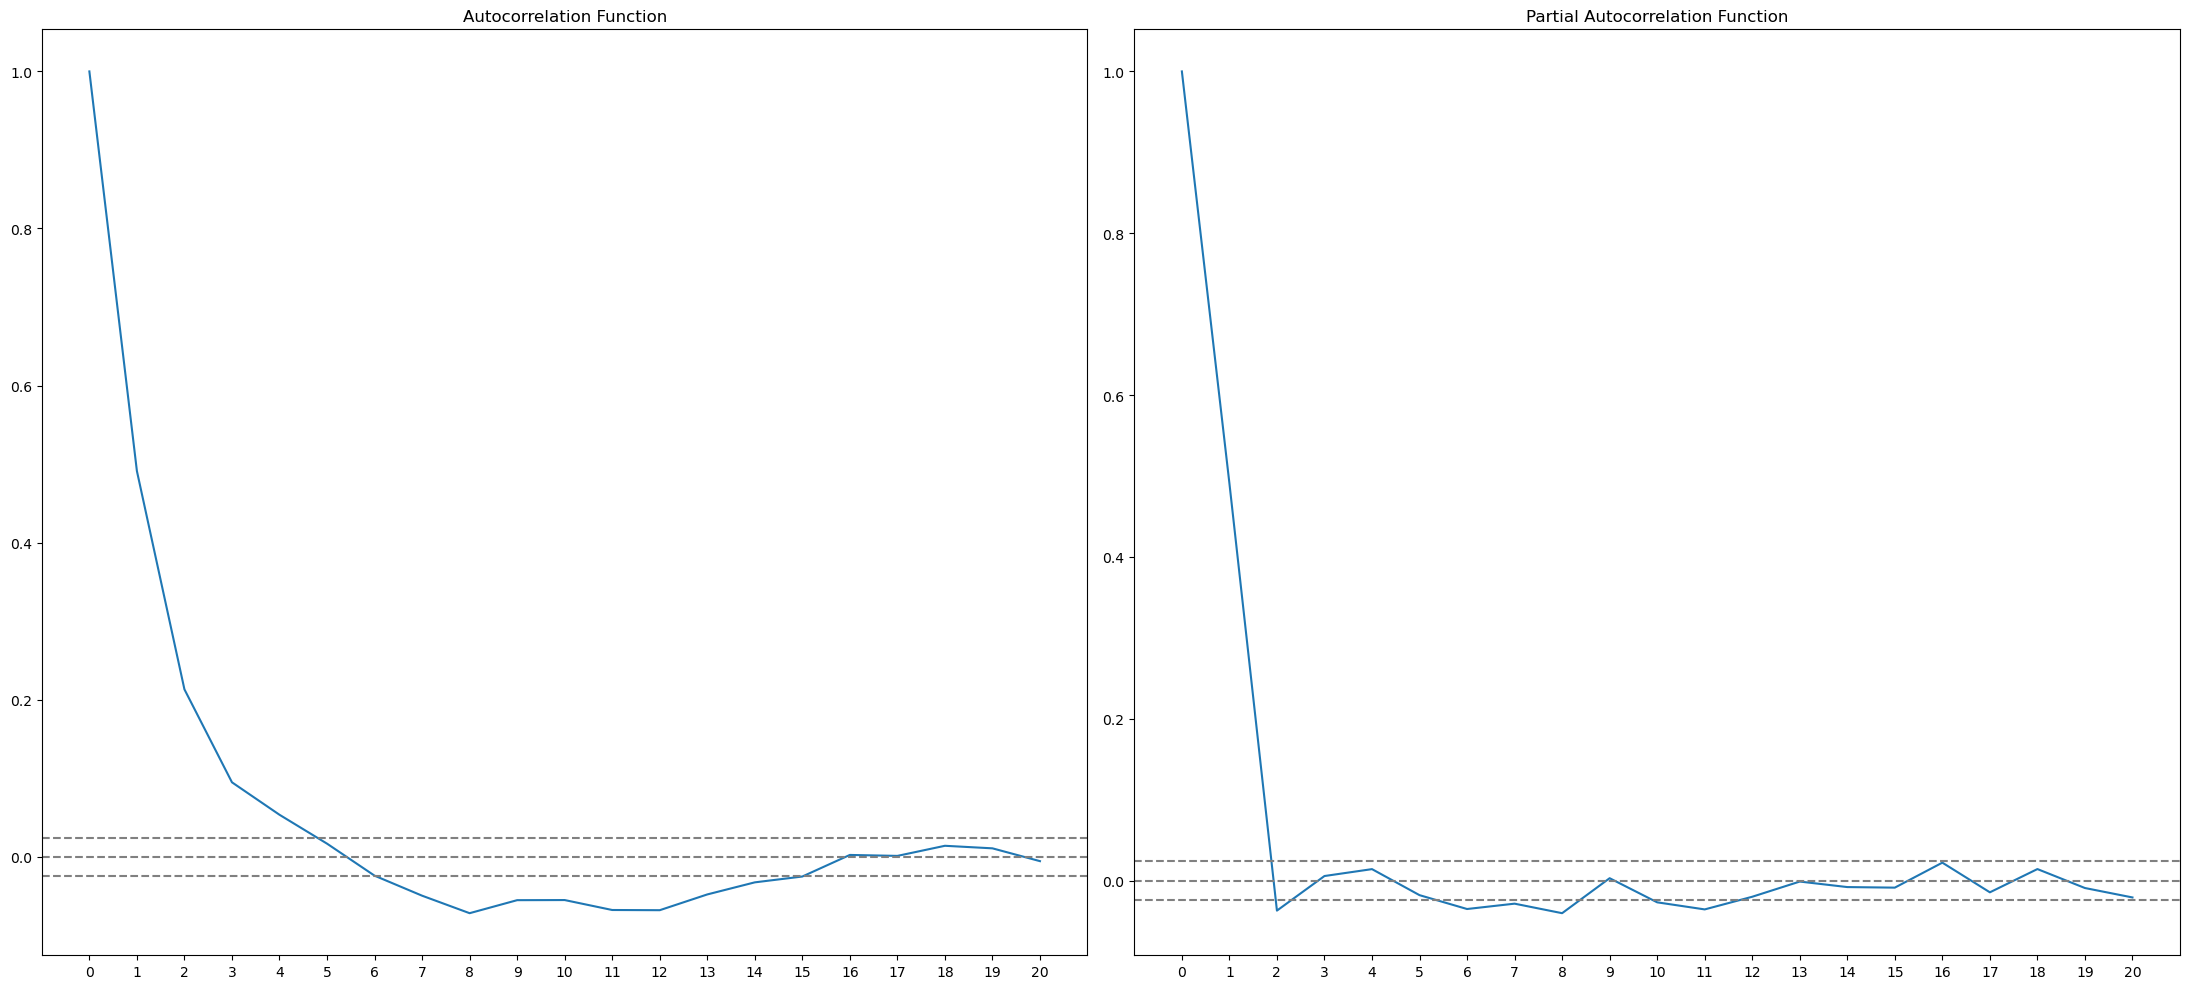

In [34]:
lag_acf = acf(ts_diff, nlags=20)
lag_pacf = pacf(ts_diff, nlags=20, method='ols')

# ACF
plt.figure(figsize=(22, 10))

plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')
plt.xticks(np.arange(0, 21, 1))  # Mettez des marques sur l'axe x tous les 1

# PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.xticks(np.arange(0, 21, 1))  # Mettez des marques sur l'axe x tous les 1

plt.tight_layout()
plt.show()

In [35]:
p=2
q=5

In [36]:
train_size = int(len(ts_diff) * 0.8)
train, test = ts_diff[:train_size], ts_diff[train_size:]

In [37]:
model = ARIMA(train, order=(2,0,5))
model_fit = model.fit()

C:\Users\edmee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\edmee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\edmee\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



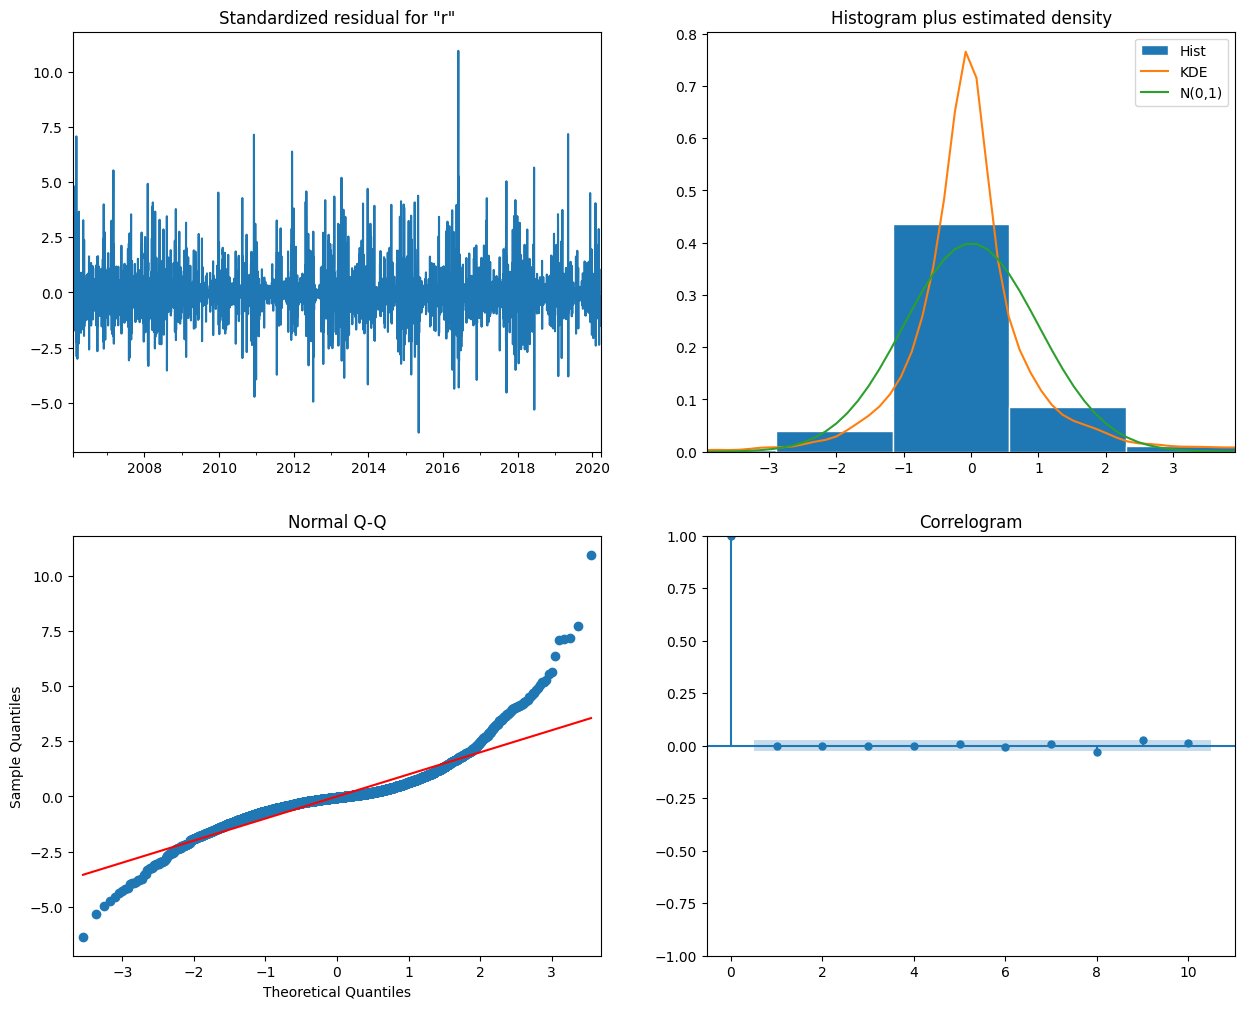

In [ ]:
model_fit.plot_diagnostics(figsize=(15,12))
plt.show()

In [38]:
start_index = test.reset_index()['date_obs_elab'].min()
end_index = test.reset_index()['date_obs_elab'].max()
forecast = model_fit.get_prediction(start=start_index, end=end_index,dynamic=True)
forecast_mean = forecast.predicted_mean
resulta=model_fit.predict(start=start_index, end=end_index)
confidence_interval = forecast.conf_int()

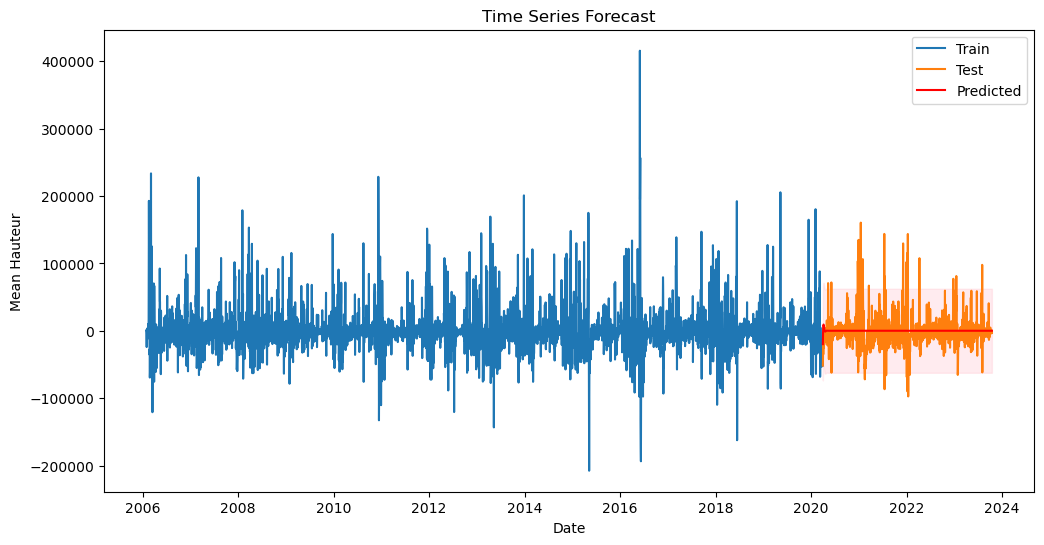

In [39]:
plt.figure(figsize=(12, 6))
plt.plot(train.reset_index()['date_obs_elab'], train.reset_index()['resultat_obs_elab'], label='Train')
plt.plot(test.reset_index()['date_obs_elab'], test.reset_index()['resultat_obs_elab'], label='Test')
plt.plot(test.reset_index()['date_obs_elab'],resulta, label='Predicted', color='red')
plt.fill_between(forecast_mean.index, confidence_interval.iloc[:, 0], confidence_interval.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Hauteur")
plt.legend()
plt.show()


In [41]:
start_index2=end_index
end_index2 = datetime(2024, 12, 31)

In [49]:


#forecast = model_fit.get_forecast(start=start_index2 ,end= end_index2 ,dynamic=True)
#forecast_mean = forecast.predicted_mean
resulta=model_fit.predict(start=start_index2, end=end_index2)
confidence_interval = forecast.conf_int()

In [47]:
new_index = pd.date_range(start=start_index2, end=end_index2)

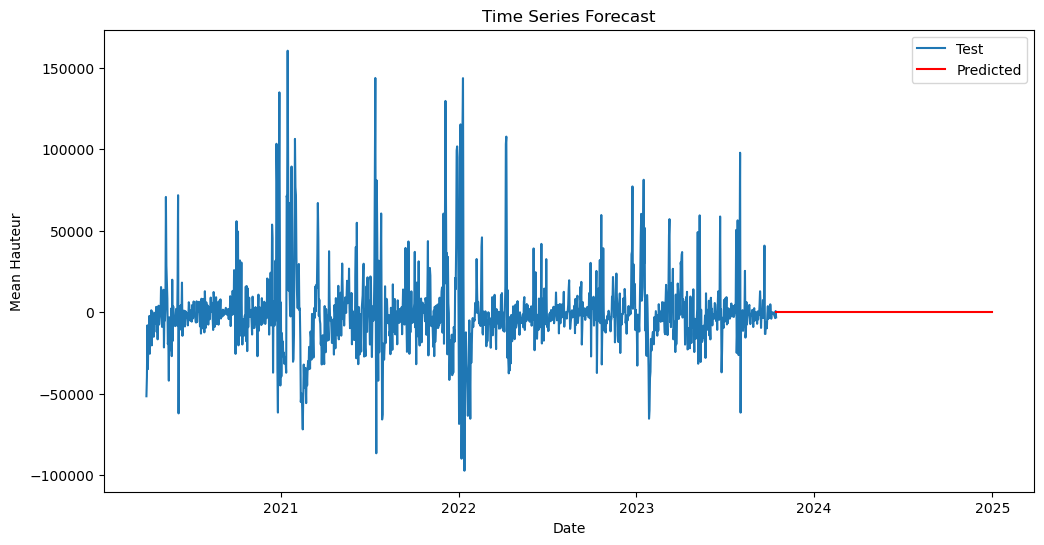

In [50]:
plt.figure(figsize=(12, 6))
plt.plot(test.reset_index()['date_obs_elab'], test.reset_index()['resultat_obs_elab'], label='Test')
plt.plot(new_index,resulta, label='Predicted', color='red')
plt.title("Time Series Forecast")
plt.xlabel("Date")
plt.ylabel("Mean Hauteur")
plt.legend()
plt.show()


# Librairie Prophet

In [66]:
pip install prophet


     ---------------------------------------- 13.3/13.3 MB 5.9 MB/s eta 0:00:00
     ---------------------------------------- 93.0/93.0 kB 5.2 MB/s eta 0:00:00
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [100]:
from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

## Construction du modèle

In [139]:
train_size = int(len(ts_diff) * 0.8)
train, test = ts_diff[:train_size], ts_diff[train_size:]

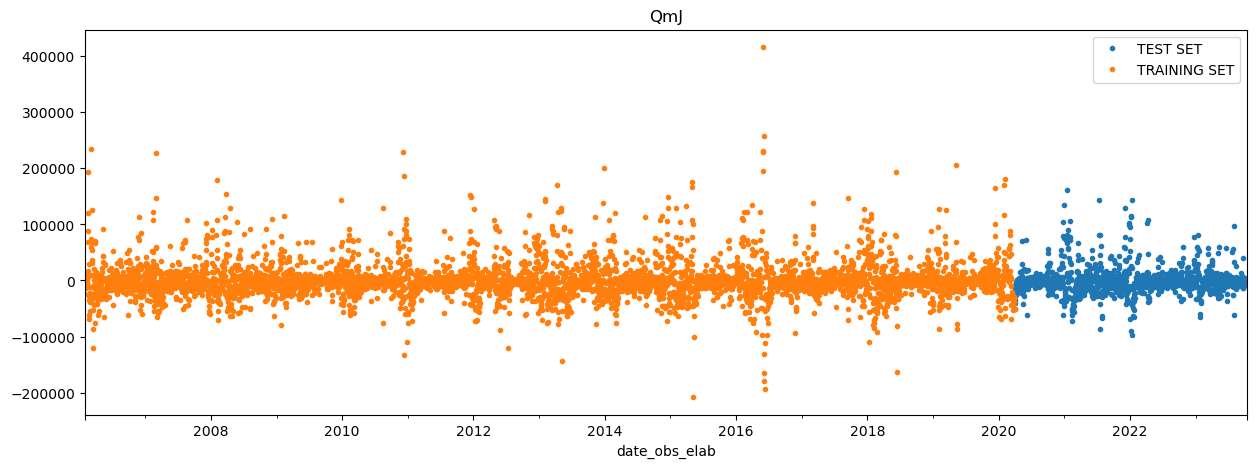

In [54]:
test \
    .rename(columns={'resultat_obs_elab': 'TEST SET'}) \
    .join(train.rename(columns={'resultat_obs_elab': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='QmJ', style='.')
plt.show()

In [133]:
train_r=train.reset_index() \
    .rename(columns={'date_obs_elab':'ds',
                     'resultat_obs_elab':'y'})
train_r

,ds,y
0,2006-01-29,315.0
1,2006-01-30,-5065.0
2,2006-01-31,-24114.0
3,2006-02-01,1738.0
4,2006-02-02,-802.0
...,...,...
5170,2020-03-26,-50319.0
5171,2020-03-27,-28725.0
5172,2020-03-28,-29859.0
5173,2020-03-29,-30674.0


In [80]:
# Setup and train model and fit
model = Prophet()
model.fit(train_r)

19:21:55 - cmdstanpy - INFO - Chain [1] start processing
19:21:58 - cmdstanpy - INFO - Chain [1] done processing


In [116]:
test_r=test.reset_index() \
    .rename(columns={'date_obs_elab':'ds',
                     'resultat_obs_elab':'y'})

In [72]:
# Predict on training set with model
test_fcst = model.predict(df=test_r)
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-31,-37.477653,-50638.141683,29784.897893,-37.477653,-37.477653,-10308.125785,-10308.125785,-10308.125785,-2014.670393,-2014.670393,-2014.670393,-8293.455392,-8293.455392,-8293.455392,0.0,0.0,0.0,-10345.603438
1,2020-04-01,-37.508740,-49850.593158,26561.661141,-37.508740,-37.508740,-10155.670607,-10155.670607,-10155.670607,-1671.162370,-1671.162370,-1671.162370,-8484.508237,-8484.508237,-8484.508237,0.0,0.0,0.0,-10193.179347
2,2020-04-02,-37.539828,-52490.710757,29879.670885,-37.539828,-37.539828,-10461.346381,-10461.346381,-10461.346381,-1861.559611,-1861.559611,-1861.559611,-8599.786770,-8599.786770,-8599.786770,0.0,0.0,0.0,-10498.886209
3,2020-04-03,-37.570915,-48873.709196,30968.909630,-37.570915,-37.570915,-8326.684727,-8326.684727,-8326.684727,311.884807,311.884807,311.884807,-8638.569534,-8638.569534,-8638.569534,0.0,0.0,0.0,-8364.255642
4,2020-04-04,-37.602003,-48637.084539,34694.905053,-37.602003,-37.602003,-6543.545266,-6543.545266,-6543.545266,2057.970147,2057.970147,2057.970147,-8601.515413,-8601.515413,-8601.515413,0.0,0.0,0.0,-6581.147269


## Représentation 

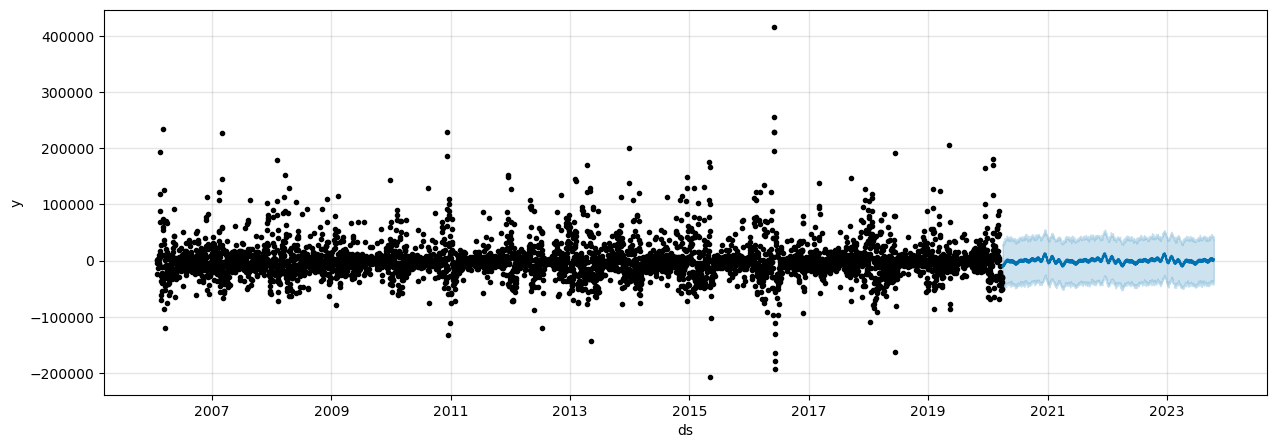

In [73]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(test_fcst,
                 ax=ax)
plt.show()

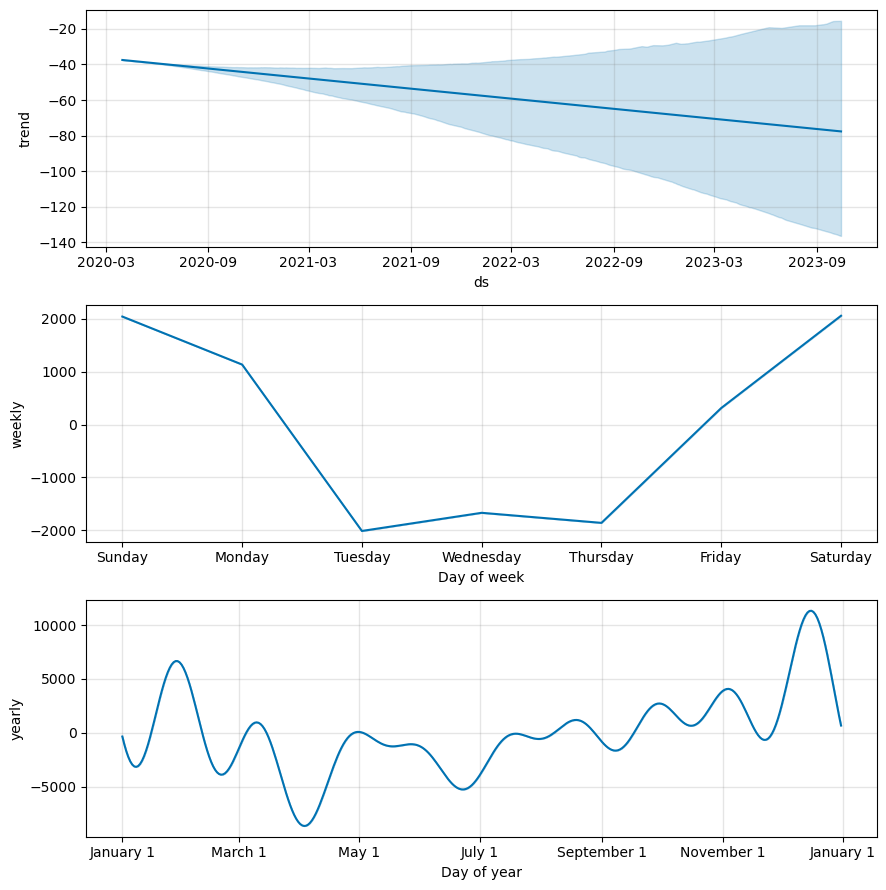

In [74]:
# Plot the components of the model
fig = model.plot_components(test_fcst)

## Comparaison

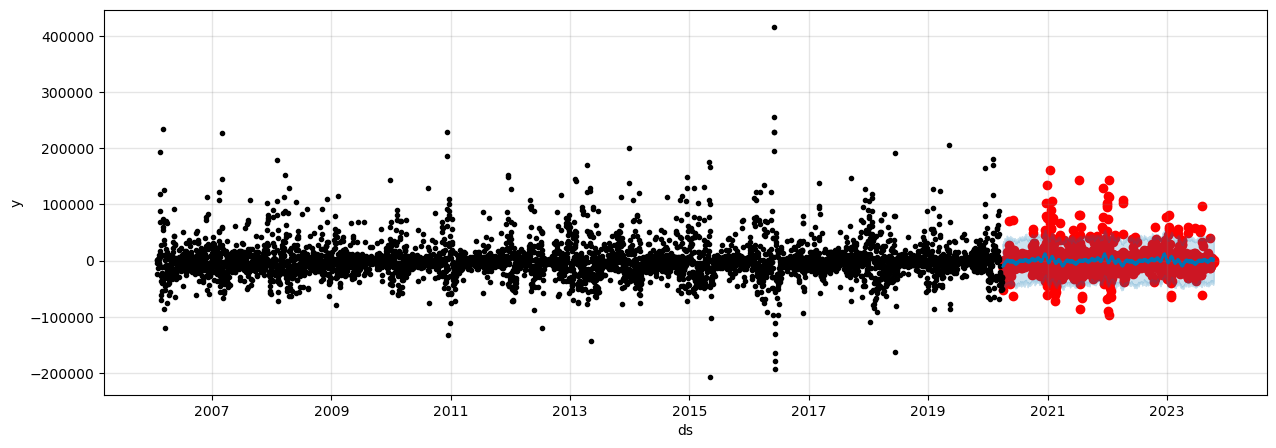

In [82]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['resultat_obs_elab'], color='r')
fig = model.plot(test_fcst, ax=ax)

In [83]:
start_index = test.reset_index()['date_obs_elab'].min()
end_index = test.reset_index()['date_obs_elab'].max()

Zoom sur le premier mois

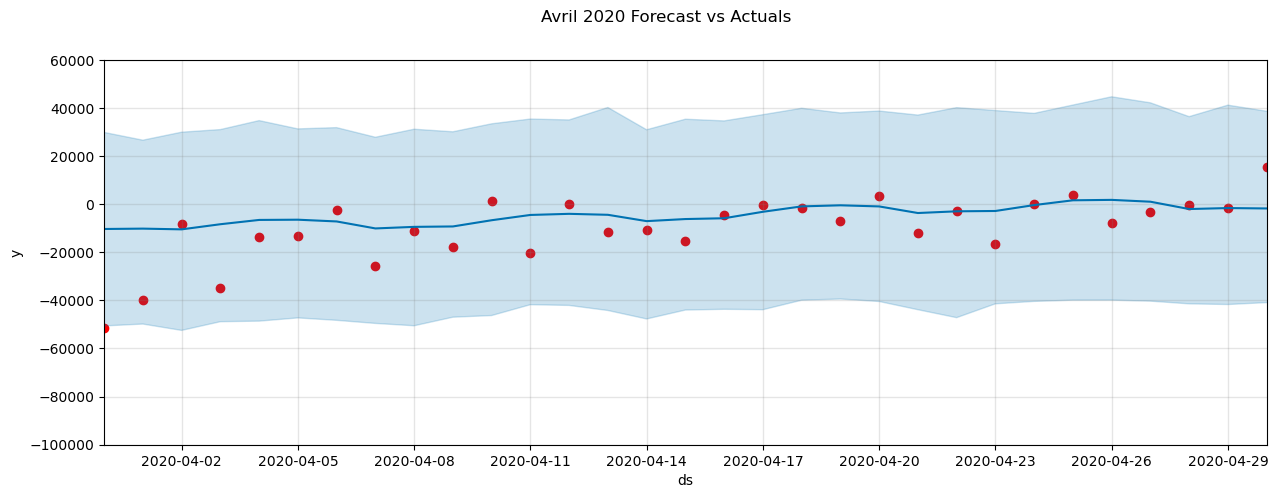

In [94]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['resultat_obs_elab'], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('31-03-2020', '%d-%m-%Y'), upper=datetime.strptime('30-04-2020', '%d-%m-%Y'))

ax.set_ylim(-100000, 60000)
plot = plt.suptitle('Avril 2020 Forecast vs Actuals')

Zoom sur la première semaine

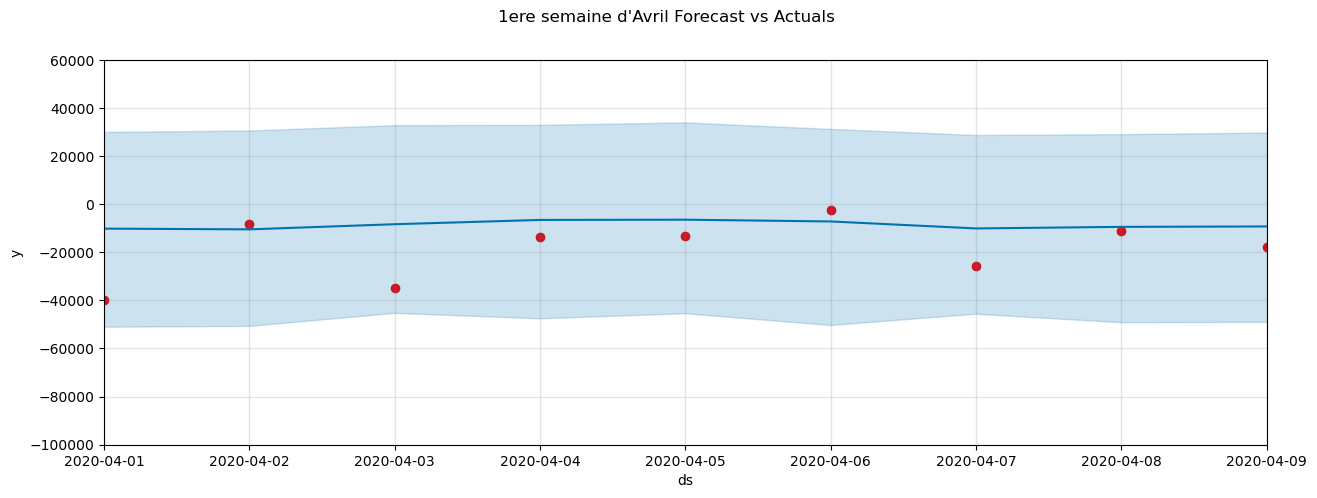

In [98]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['resultat_obs_elab'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower=datetime.strptime('01-04-2020', '%d-%m-%Y'), upper=datetime.strptime('09-04-2020', '%d-%m-%Y'))

ax.set_ylim(-100000, 60000)
plot = plt.suptitle('1ere semaine d\'Avril Forecast vs Actuals')

## Erreur

In [101]:
mean_squared_error(y_true=test['resultat_obs_elab'],
                   y_pred=test_fcst['yhat'])

574729677.811574

In [102]:
mean_absolute_error(y_true=test['resultat_obs_elab'],
                   y_pred=test_fcst['yhat'])

14568.096994240701

In [103]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['resultat_obs_elab'],
                   y_pred=test_fcst['yhat'])

247.23899463492046

## Futur

In [163]:
# Create a DataFrame for future dates
future = model.make_future_dataframe(periods=3096)

# Generate forecast
forecast = model.predict(future)


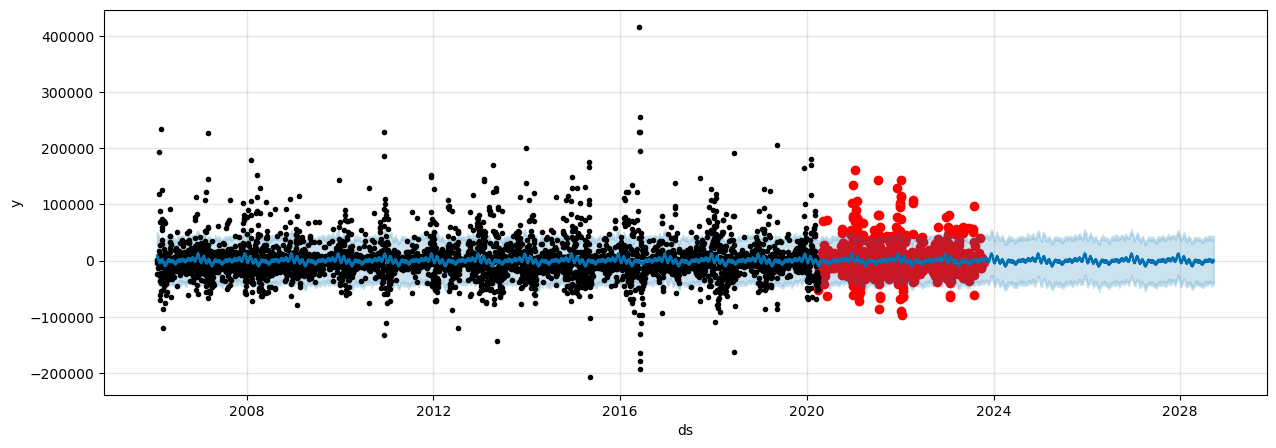

In [108]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['resultat_obs_elab'], color='r')
fig = model.plot(forecast, ax=ax)

## Outliers

In [ ]:
start_index = train_r.reset_index()['date_obs_elab'].min()
end_index = train_r.reset_index()['date_obs_elab'].max()

In [169]:
train_r=train.reset_index() \
    .rename(columns={'date_obs_elab':'ds',
                     'resultat_obs_elab':'y'})

In [141]:
train.reset_index()['date_obs_elab'].min()

Timestamp('2006-01-29 00:00:00')

In [166]:
train_r[train_r["y"].notna()]


,ds,y
0,2006-01-29,315.0
1,2006-01-30,-5065.0
2,2006-01-31,-24114.0
3,2006-02-01,1738.0
4,2006-02-02,-802.0
...,...,...
5168,2020-03-24,-39683.0
5169,2020-03-25,-38139.0
5171,2020-03-27,-28725.0
5172,2020-03-28,-29859.0


In [170]:

# Replace outliers with NaN

#outliers_condition = (train_r['ds'].dt.date > start_index) & (train_r['ds'].dt.date < end_index)
#train_r.loc[outliers_condition, 'y'] = None

# Identify outliers using the IQR method
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    outliers = (data[column] < lower_bound) | (data[column] > upper_bound)
    return outliers

# Apply the function to identify outliers in the 'y' column
outliers = identify_outliers(train_r, 'y')

train_r.loc[outliers, 'y'] = None


In [171]:
m = Prophet()

# Fit the model with your data
m.fit(train_r)

# Create a DataFrame for future dates
#future = m.make_future_dataframe(periods=1096)

# Generate forecast
test_fcst2 = m.predict(test_r)

20:22:31 - cmdstanpy - INFO - Chain [1] start processing
20:22:32 - cmdstanpy - INFO - Chain [1] done processing


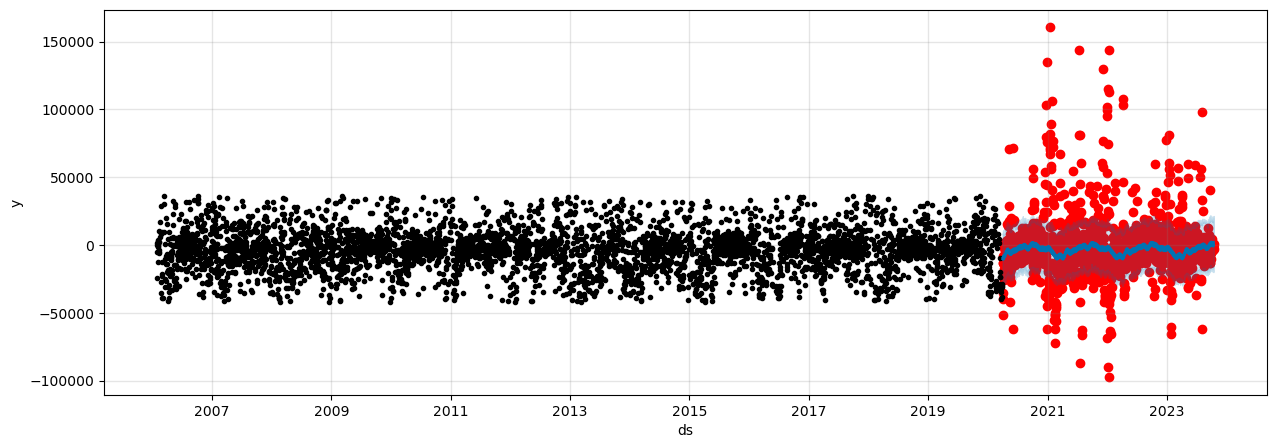

In [172]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(test.index, test['resultat_obs_elab'], color='r')
fig = m.plot(test_fcst2, ax=ax)

In [173]:

mean_squared_error(y_true=test['resultat_obs_elab'],
                   y_pred=test_fcst2['yhat'])



575940023.0562353

In [174]:
mean_absolute_error(y_true=test['resultat_obs_elab'],
                   y_pred=test_fcst2['yhat'])

14097.461927728944

In [175]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=test['resultat_obs_elab'],
                   y_pred=test_fcst2['yhat'])

287.51544453260874